## 问题定义

待求解问题为一个三滑块的弹簧系统。两侧固定墙壁中有三个滑块，三个滑块从左至右使用四个弹簧连接。弹簧沿着无摩擦的水平表面滑行。假设滑块为点质量，弹簧无质量。四个弹簧等长
![Problem](./resource/problem.png)

这个系统遵循如下的ODE方程组：
![equation](./resource/equation.png)

其中，$m_1, m_2, m_3$分别为三个滑块的质量；$k_1, k_2, k_3, k_4$为四个弹簧的劲度系数；$x_1, x_2, x_3$为三个滑块的位置（使用相对位置，即相对于平衡位置的偏移距离，右加左减）；$^{\prime\prime}$为二阶导数。


### 求解目标

假定滑块质量和弹簧的劲度系数恒定。要求求解三个滑块位置关于时间的函数。

总体而言，方程明确，初始条件为静态，第一个滑块向右偏移了一个单位。


## 求解

In [1]:
import os
import warnings

# optional
# set appropriate GPU in case of multi-GPU machine
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
from sympy import Symbol, Function, Number

import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra import instantiate_arch, ModulusConfig
from modulus.sym.hydra.utils import compose
from modulus.sym.solver import Solver
from modulus.sym.domain import Domain
from modulus.sym.geometry.primitives_1d import Point1D

from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
)
from modulus.sym.domain.validator import PointwiseValidator
from modulus.sym.key import Key
from modulus.sym.node import Node

from modulus.sym.eq.pde import PDE

from spring_mass_ode import SpringMass

In [3]:
cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:148: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: ${training.rec_results_freq}
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: false
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: fal

### 定义必要组件

#### PDE

本案例特殊之处在于需要自行定义PDE

自定义PDE通过继承抽象基类(modulus.sym.eq.pde.PDE)实现

In [4]:
class SpringMass(PDE):
    name = "SpringMass"

    def __init__(self, k=(2, 1, 1, 2), m=(1, 1, 1)):
        
        # 劲度系数
        self.k = k
        # 质量
        self.m = m

        k1 = k[0]
        k2 = k[1]
        k3 = k[2]
        k4 = k[3]
        m1 = m[0]
        m2 = m[1]
        m3 = m[2]

        t = Symbol("t")
        input_variables = {"t": t}

        x1 = Function("x1")(*input_variables)
        x2 = Function("x2")(*input_variables)
        x3 = Function("x3")(*input_variables)
        
        # 判断劲度系数是否是可学习参数
        if type(k1) is str:
            k1 = Function(k1)(*input_variables)
        elif type(k1) in [float, int]:
            k1 = Number(k1)
        if type(k2) is str:
            k2 = Function(k2)(*input_variables)
        elif type(k2) in [float, int]:
            k2 = Number(k2)
        if type(k3) is str:
            k3 = Function(k3)(*input_variables)
        elif type(k3) in [float, int]:
            k3 = Number(k3)
        if type(k4) is str:
            k4 = Function(k4)(*input_variables)
        elif type(k4) in [float, int]:
            k4 = Number(k4)

        # 判断质量是否是可学习参数
        if type(m1) is str:
            m1 = Function(m1)(*input_variables)
        elif type(m1) in [float, int]:
            m1 = Number(m1)
        if type(m2) is str:
            m2 = Function(m2)(*input_variables)
        elif type(m2) in [float, int]:
            m2 = Number(m2)
        if type(m3) is str:
            m3 = Function(m3)(*input_variables)
        elif type(m3) in [float, int]:
            m3 = Number(m3)
        
        # ode方程组
        self.equations = {}
        self.equations["ode_x1"] = m1 * (x1.diff(t)).diff(t) + k1 * x1 - k2 * (x2 - x1)
        self.equations["ode_x2"] = (
            m2 * (x2.diff(t)).diff(t) + k2 * (x2 - x1) - k3 * (x3 - x2)
        )
        self.equations["ode_x3"] = m3 * (x3.diff(t)).diff(t) + k3 * (x3 - x2) + k4 * x3

sm = SpringMass(k=(2, 1, 1, 2), m=(1, 1, 1))

#### Model

In [5]:
# 输入为时间坐标
# 输出为三个质点的偏移量
sm_net = instantiate_arch(
        input_keys=[Key("t")],
        output_keys=[Key("x1"), Key("x2"), Key("x3")],
        cfg=cfg.arch.fully_connected,
    )
print(sm_net)

nodes = sm.make_nodes() + [sm_net.make_node(name="spring_mass_network")]

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=1, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)


#### Geo

In [6]:
# 定义求解区域
# 本问题中，x范围无明确定义，t范围为[0, 10]
# 注意这里声明的特殊geo
# 由于输入是t，输出是三个质点的坐标，因此不需要在空间上进行采样，因此设置为Point1D
geo = Point1D(0)
t_max = 10.0
t_symbol = Symbol("t")
x = Symbol("x")
time_range = {t_symbol: (0, t_max)}

#### Domain

在Domain中定义约束以及训练所需的各种组件

In [7]:
# make domain
domain = Domain()

本求解无边界条件

#### 初始条件

初始条件为三个质点的相对偏移量以及速度（$__t$）

In [8]:
# initial condition
IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": 1.0, "x2": 0, "x3": 0, "x1__t": 0, "x2__t": 0, "x3__t": 0},
        batch_size=cfg.batch_size.IC,
        lambda_weighting={
            "x1": 1.0,
            "x2": 1.0,
            "x3": 1.0,
            "x1__t": 1.0,
            "x2__t": 1.0,
            "x3__t": 1.0,
        },
        parameterization={t_symbol: 0},
    )
domain.add_constraint(IC, name="IC")

内部满足ODE约束

In [9]:
# interior
interior = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0, "ode_x2": 0.0, "ode_x3": 0.0},
        batch_size=cfg.batch_size.interior,
        parameterization=time_range,
    )
domain.add_constraint(interior, "interior")

验证器以及其他必要组件

In [10]:
# 解析解
deltaT = 0.001
t = np.arange(0, t_max, deltaT)
t = np.expand_dims(t, axis=-1)
invar_numpy = {"t": t}
outvar_numpy = {
    "x1": (1 / 6) * np.cos(t) + (1 / 2) * np.cos(np.sqrt(3) * t) + (1 / 3) * np.cos(2 * t),
    "x2": (2 / 6) * np.cos(t) + (0 / 2) * np.cos(np.sqrt(3) * t) - (1 / 3) * np.cos(2 * t),
    "x3": (1 / 6) * np.cos(t) - (1 / 2) * np.cos(np.sqrt(3) * t) + (1 / 3) * np.cos(2 * t),
}

# validator
validator = PointwiseValidator(
    nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=1024
)
domain.add_validator(validator)

### 求解器以及求解

In [11]:
# 定义求解器
slv = Solver(cfg, domain)

手动加载日志系统

In [12]:
import logging
# logging.getLogger().addHandler(logging.StreamHandler())
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

启动求解

In [13]:
slv.solve()

2024-02-18 09:02:55,220 - modulus.sym.trainer - WARNING - Installed PyTorch version 2.2.0a0+81ea7a4 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
2024-02-18 09:02:55,226 - modulus.sym.trainer - INFO - attempting to restore from: /workspace/03_ODE_SpringMassSystem/outputs
2024-02-18 09:02:55,227 - modulus.sym.trainer - WARNING - optimizer checkpoint not found
2024-02-18 09:02:55,227 - modulus.sym.trainer - WARNING - model spring_mass_network.0.pth not found
2024-02-18 09:02:56,301 - modulus.sym.trainer - INFO - [step:          0] record constraint batch time:  3.936e-02s
2024-02-18 09:02:56,350 - modulus.sym.trainer - INFO - [step:          0] record validators time:  4.662e-02s
2024-02-18 09:02:56,372 - modulus.sym.trainer - INFO - [step:          0] saved checkpoint to /workspace/03_ODE_SpringMassSystem/outputs
2024-02-18 09:02:56,374 - modulus.sym.trainer - INFO - [step:          0] loss:  9.073e+00
2024-02-18 09:02:57,990 - modulus.sym.tra

2024-02-18 09:03:40,775 - modulus.sym.trainer - INFO - [step:       4800] loss:  3.349e-02, time/iteration:  6.576e+00 ms
2024-02-18 09:03:41,435 - modulus.sym.trainer - INFO - [step:       4900] loss:  2.735e-02, time/iteration:  6.582e+00 ms
2024-02-18 09:03:42,186 - modulus.sym.trainer - INFO - [step:       5000] record constraint batch time:  4.641e-02s
2024-02-18 09:03:42,227 - modulus.sym.trainer - INFO - [step:       5000] record validators time:  3.978e-02s
2024-02-18 09:03:42,254 - modulus.sym.trainer - INFO - [step:       5000] saved checkpoint to /workspace/03_ODE_SpringMassSystem/outputs
2024-02-18 09:03:42,256 - modulus.sym.trainer - INFO - [step:       5000] loss:  2.818e-02, time/iteration:  8.197e+00 ms
2024-02-18 09:03:42,918 - modulus.sym.trainer - INFO - [step:       5100] loss:  2.774e-02, time/iteration:  6.614e+00 ms
2024-02-18 09:03:43,578 - modulus.sym.trainer - INFO - [step:       5200] loss:  2.276e-02, time/iteration:  6.577e+00 ms
2024-02-18 09:03:44,236 - m

2024-02-18 09:04:16,200 - modulus.sym.trainer - INFO - [step:      10000] record validators time:  4.016e-02s
2024-02-18 09:04:16,228 - modulus.sym.trainer - INFO - [step:      10000] saved checkpoint to /workspace/03_ODE_SpringMassSystem/outputs
2024-02-18 09:04:16,231 - modulus.sym.trainer - INFO - [step:      10000] loss:  6.549e-04, time/iteration:  8.180e+00 ms
2024-02-18 09:04:16,231 - modulus.sym.trainer - INFO - [step:      10000] reached maximum training steps, finished training!


### 后处理以及可视化

对于jupyter，比较方便的方法是使用matplotlib

此外，还可以使用tensorboard以及Paraview

如果使用了PointwiseValidator则可以直接查看验证的结果

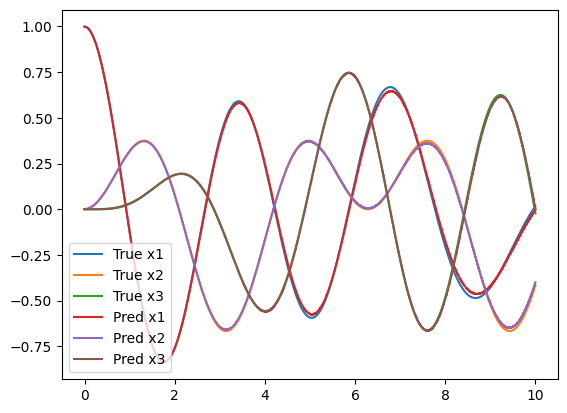

In [17]:
import numpy as np
import matplotlib.pyplot as plt

base_dir = "outputs/validators/"

# plot in 1d
data = np.load(base_dir + "validator.npz", allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]

plt.plot(data["t"], data["true_x1"], label="True x1")
plt.plot(data["t"], data["true_x2"], label="True x2")
plt.plot(data["t"], data["true_x3"], label="True x3")
plt.plot(data["t"], data["pred_x1"], label="Pred x1")
plt.plot(data["t"], data["pred_x2"], label="Pred x2")
plt.plot(data["t"], data["pred_x3"], label="Pred x3")
plt.legend()
plt.show();

预测结果和解析解匹配的很好